# U-Net Architecture

In [18]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from PIL import Image
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

# U-Net Architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Define encoder layers
        self.enc1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Define bottleneck layer
        self.bottleneck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        
        # Define decoder layers with concatenation in mind
        self.dec4 = nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1)
        self.dec3 = nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1)
        self.dec2 = nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        self.dec1 = nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1)
        
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Output single-channel heatmap

    def forward(self, x):
        # Encoder with max-pooling
        x1 = F.relu(self.enc1(x))
        x2 = F.relu(self.enc2(F.max_pool2d(x1, 2)))
        x3 = F.relu(self.enc3(F.max_pool2d(x2, 2)))
        x4 = F.relu(self.enc4(F.max_pool2d(x3, 2)))
        
        # Bottleneck
        x = F.relu(self.bottleneck(F.max_pool2d(x4, 2)))
        
        # Decoder with upsampling and concatenation of encoder outputs
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x4], dim=1)  # Concatenate encoder output from enc4
        x = F.relu(self.dec4(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)  # Concatenate encoder output from enc3
        x = F.relu(self.dec3(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)  # Concatenate encoder output from enc2
        x = F.relu(self.dec2(x))
        
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)  # Concatenate encoder output from enc1
        x = F.relu(self.dec1(x))
        
        # Final layer (no activation for regression tasks)
        return self.final(x)

# Training Model (do not run!)

In [19]:
# Helper function to find image file by ID
def find_image_path(directory, prefix, image_id):
    path = os.path.join(directory, f"{prefix}_id{image_id}.png")
    return path if os.path.exists(path) else None

# Custom Dataset class for Satellite and Heatmap images
class SatelliteHeatmapDataset(Dataset):
    def __init__(self, satellite_dir, heatmap_dir, transform=None):
        self.satellite_dir = satellite_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.satellite_ids = [os.path.splitext(f)[0].split('_id')[-1] 
                              for f in os.listdir(satellite_dir) if os.path.isfile(os.path.join(satellite_dir, f))]

    def __len__(self):
        return len(self.satellite_ids)

    def __getitem__(self, idx):
        image_id = self.satellite_ids[idx]
        satellite_path = find_image_path(self.satellite_dir, "satellite", image_id)
        heatmap_path = find_image_path(self.heatmap_dir, "heatmap", image_id)
        if satellite_path is None or heatmap_path is None:
            print(f"File not found: {satellite_path} or {heatmap_path}")
            return None
        satellite_image = Image.open(satellite_path)
        heatmap_image = Image.open(heatmap_path)
        if self.transform:
            satellite_image = self.transform(satellite_image)
            heatmap_image = self.transform(heatmap_image)
        return satellite_image, heatmap_image

# Custom collate function to filter out None values
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)
    return torch.utils.data.default_collate(batch)

# Directories containing satellite and heatmap images
satellite_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite'
heatmap_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Heatmap'

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Initialize the dataset
dataset = SatelliteHeatmapDataset(satellite_dir, heatmap_dir, transform=transform)

# Split the IDs into training and validation sets
train_ids, val_ids = train_test_split(dataset.satellite_ids, test_size=0.2, random_state=42)

class SplitSatelliteHeatmapDataset(Dataset):
    def __init__(self, satellite_dir, heatmap_dir, ids, transform=None):
        self.satellite_dir = satellite_dir
        self.heatmap_dir = heatmap_dir
        self.transform = transform
        self.ids = ids

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        satellite_path = find_image_path(self.satellite_dir, "satellite", image_id)
        heatmap_path = find_image_path(self.heatmap_dir, "heatmap", image_id)
        if satellite_path is None or heatmap_path is None:
            #print(f"File not found: {satellite_path} or {heatmap_path}")
            return None
        satellite_image = Image.open(satellite_path)
        heatmap_image = Image.open(heatmap_path)
        if self.transform:
            satellite_image = self.transform(satellite_image)
            heatmap_image = self.transform(heatmap_image)
        return satellite_image, heatmap_image

# Create separate datasets
train_dataset = SplitSatelliteHeatmapDataset(satellite_dir, heatmap_dir, train_ids, transform=transform)
val_dataset = SplitSatelliteHeatmapDataset(satellite_dir, heatmap_dir, val_ids, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

# Initialize model
model = UNet()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop with graceful KeyboardInterrupt handling
def train_model(model, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    
    try:
        for epoch in range(num_epochs):
            model.train()  # Set model to training mode
            running_loss = 0.0
            
            # Initialize progress bar for this epoch
            with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
                for satellite_images, heatmap_images in train_loader:
                    optimizer.zero_grad()
                    outputs = model(satellite_images)
                    loss = criterion(outputs, heatmap_images)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    pbar.update(1)
                    pbar.set_postfix(loss=loss.item())  # Update the progress bar with the current loss

            train_losses.append(running_loss / len(train_loader))
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

            # Evaluate on validation set
            val_loss = evaluate_model(model, val_loader)
            val_losses.append(val_loss)
            print(f"Validation Loss: {val_loss}")
    
    except KeyboardInterrupt:
        print("Training interrupted! Plotting current progress...")

    # Plot the training and validation loss even if interrupted
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

def evaluate_model(model, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for satellite_images, heatmap_images in val_loader:
            outputs = model(satellite_images)
            loss = criterion(outputs, heatmap_images)
            val_loss += loss.item()
    return val_loss / len(val_loader)


train_model(model, train_loader, val_loader, num_epochs=50)
torch.save(model.state_dict(), "/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet.pth")


Epoch [1/50]:  25%|██▌       | 2/8 [05:26<16:13, 162.24s/batch, loss=0.0595]

# Prediction

/var/folders/23/bgygmh4x281cznmrp1yt_r1h0000gn/T/ipykernel_72052/1578656197.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jann

Predicted heatmap saved to /Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction/prediction_id712.png


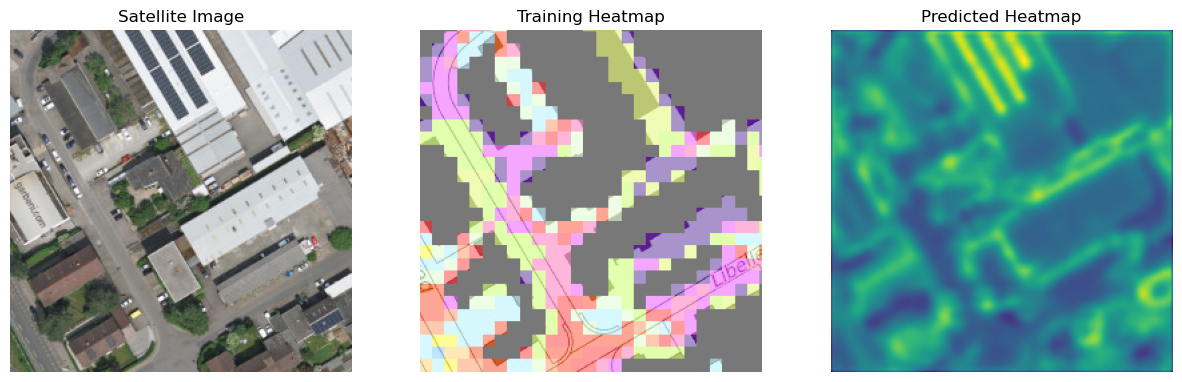

In [9]:
# Load the trained model
model = UNet()
model.load_state_dict(torch.load("/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/03TrainedModel/satellite_to_heatmap_unet.pth"))
model.eval()  # Set model to evaluation mode

# Directories
output_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Prediction'
satellite_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Satellite'
heatmap_dir = '/Users/janne/Library/CloudStorage/OneDrive-ETHZurich/ML_Shared/Images/Heatmap'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to predict and display heatmap for a random satellite image
def predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform):
    satellite_files = os.listdir(satellite_dir)
    random_file = random.choice(satellite_files)
    
    # Load and transform the satellite image
    satellite_image_path = os.path.join(satellite_dir, random_file)
    satellite_image = Image.open(satellite_image_path)
    satellite_tensor = transform(satellite_image).unsqueeze(0)  # Add batch dimension

    # Load the corresponding training heatmap
    heatmap_image_path = os.path.join(heatmap_dir, random_file.replace("satellite", "heatmap"))
    heatmap_image = Image.open(heatmap_image_path)

    # Predict the heatmap
    with torch.no_grad():
        predicted_heatmap = model(satellite_tensor)

    # Remove batch dimension and convert to numpy
    predicted_heatmap = predicted_heatmap.squeeze(0).squeeze(0).cpu().numpy()

    # Save the predicted heatmap
    output_file = random_file.replace("satellite", "prediction")
    output_path = os.path.join(output_dir, output_file)
    save_image(torch.tensor(predicted_heatmap).unsqueeze(0), output_path)
    print(f"Predicted heatmap saved to {output_path}")

    # Display the satellite image, training heatmap, and predicted heatmap
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(satellite_image)
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_image)
    plt.title("Training Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_heatmap, cmap='viridis')
    plt.title("Predicted Heatmap")
    plt.axis("off")

    plt.show()

# Run the prediction and display
predict_and_display_heatmap(model, satellite_dir, heatmap_dir, output_dir, transform)